# Imports

In [1]:
# Importing the required packages
import datetime
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import seaborn as sb
import matplotlib.pyplot as plt

from functions.statistical_functions import*
from functions.coefficient_table import*
from functions.format_data import*
from functions.distributions import*
#from functions.stat_relationship import*
import scipy.stats as sci

# DataFiles

In [2]:
# importing the data 
RF_Data = pd.read_csv("C:\\Users\\Ritvik Bale\\Documents\\Research\\Systemic Risk Research\\Risk Factor Data v1.csv")
Bank_Data = pd.read_csv("C:\\Users\\Ritvik Bale\\Documents\\Research\\Systemic Risk Research\\Bank data v1 2020-08-24.csv")
OFR_Data = pd.read_csv("C:\\Users\\Ritvik Bale\\Documents\\Research\\Systemic Risk Research\\fsi.csv")
QLY = pd.read_csv("C:\\Users\\Ritvik Bale\\Documents\\Research\\Systemic Risk Research\\Compustat qly 1972-12 to 2020-09 fundamentals.csv")
MLY = pd.read_csv("C:\\Users\\Ritvik Bale\\Documents\\Research\\Systemic Risk Research\\Compustat mthly 1972-12-31 to 2020-12-31 security.csv")

# converting the raw data to DataFrames
RF_Data = pd.DataFrame(RF_Data)
Bank_Data = pd.DataFrame(Bank_Data)

#Formatting the 2 datasets
RF_Data = format_RF_data(RF_Data)
Bank_Data = format_bank_data(Bank_Data)

C:\Users\Ritvik Bale\Anaconda3\lib\site-packages\pandas\core\frame.py:3990: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


# Cleaning up the MLY DataFrame

In [3]:
MLY = MLY.dropna()

In [4]:
one = np.array(MLY["Data Date - Security Monthly"])

#Convertine the dates to strings
x = []
for i in one:
    x.append(str(i))

In [5]:
#Converting the string dates to string datetimes
one = []
for i in x:
    date = datetime.datetime.strptime(i, "%Y%m%d")
    one.append(date)

#Adding the new datetimes as the dates in the QLY dataframe
MLY["Data Date - Security Monthly"] = one

In [6]:
counter = []
for i in range(np.size(one)):
    if one[i].month%3 != 0:
        counter.append(i)

In [7]:
size = np.size(MLY["Data Date - Security Monthly"])
MLY.index = np.arange(0,size)

In [8]:
MLY = MLY.drop(counter)

In [9]:
size = np.size(MLY["Data Date - Security Monthly"])
MLY.index = np.arange(0,size)

# Cleaning Up the QLY DataFrame

In [10]:
QLY = QLY.dropna()

In [11]:
one = np.array(QLY["Data Date"])

#Convertine the dates to strings
x = []
for i in one:
    x.append(str(i))

In [12]:
#Converting the string dates to string datetimes
one = []
for i in x:
    date = datetime.datetime.strptime(i, "%Y%m%d")
    one.append(date)

#Adding the new datetimes as the dates in the QLY dataframe
QLY["Data Date"] = one

In [13]:
counter = []
for i in range(np.size(one)):
    if one[i].month%3 != 0:
        counter.append(i)

In [14]:
size = np.size(QLY["Data Date"])
QLY.index = np.arange(0,size)

In [15]:
QLY = QLY.drop(counter)

In [16]:
size = np.size(QLY["Data Date"])
QLY.index = np.arange(0,size)

# Linking the QLY and the MLY DataFrames

In [17]:
returns = []
drop = []
QLY = QLY[:10000]
MLY = MLY[:10000]
for ind, i in QLY.iterrows():
    ticker = QLY.loc[ind, "Ticker Symbol"]
    date = QLY.loc[ind, "Data Date"]
    M = MLY.loc[(MLY["Data Date - Security Monthly"] == date) & (MLY["Ticker Symbol"] == ticker)].index
    M = MLY.loc[M, "Monthly Total Return"]
    if M.size > 0 :
        M.index = [0]
        ret = M[0]
    else:
        ret = 0
        drop.append(ind)
    returns.append(ret)

In [18]:
QLY["Returns"] = returns

In [19]:
QLY = QLY.drop(drop)

In [20]:
QLY.index = np.arange(0, 2983)

In [21]:
A = QLY["Current Assets - Total"]/QLY["Assets - Total"]
B = QLY["Retained Earnings"]/QLY["Assets - Total"]
C = (QLY["Retained Earnings"]+QLY["Interest and Related Expense- Total"])/QLY["Assets - Total"]
D = QLY["Net Income (Loss)"]/QLY["Current Liabilities - Total"]
E = QLY["Sales/Turnover (Net)"]/QLY["Assets - Total"]

z_scores = 1.2*A + 1.4*B + 3.3*C + 0.6*D + 1*E


In [22]:
QLY["Z_Scores"] = z_scores

In [26]:
sci.pearsonr(QLY["Z_Scores"], QLY["Current Liabilities - Total"])

(-0.046021492875111335, 0.011942890823761819)

# Return Table

In [24]:
Return_Table = return_table(Bank_Data, RF_Data)

# Coefficient DataFrame

In [96]:
def coeff(Return_Table, PERMNO, start_year, end_year, start_month, end_month):
    
    Coefficient_Table = []
    
    #Iterate over all firms
    for i in PERMNO:

        #Initializing the Coefficient_Table Array
        #Create a Return table for each firm - consisting of only the dates that have been specified
        Single_Firm = Return_Table.loc[Return_Table['PERMNO'] == i]
        
        #Modifying the DataFrame to only include returns from the specified dates
        Single_Firm = Single_Firm.loc[(Single_Firm.Year >= start_year) & (Single_Firm.Year <= end_year)]
        #Only including the dates that are after the start month of the start year
        Single_Firm = Single_Firm.loc[(Single_Firm.Month >= start_month) | (Single_Firm.Year > start_year)]
        #Only including the dates that are before the end month of the end year
        Single_Firm = Single_Firm.loc[(Single_Firm.Month <= end_month) | (Single_Firm.Year < end_year)]

        #Setting the X Variables to be regressed on (Risk Factors), and setting the Y Variable that will be regressed (Bank Returns)
        y = Single_Firm['Return']
        x = Single_Firm[['bond', 'credit', 'sp500', 'cmdty', 'dvix', 'dhouse']]

        #Conducting the Linear Regression
        if len(x['bond']) > 1:
            
            corr = []
            for i in x:
                corr.append(np.abs(sci.pearsonr(x[i], y)[0]))
            
            norm_corr = []
            for i in range(len(corr)):
                val = corr[i]/np.sum(corr)
                norm_corr.append(val)

            Coefficient_Table.append(norm_corr)
    
    #Formatting the Coefficient Table as a DataFrame
    Coefficient_Table = pd.DataFrame(Coefficient_Table, columns = ['bond', 'credit', 'sp500', 'cmdty', 'dvix', 'dhouse'])
    return Coefficient_Table

In [97]:
Return_Table['dhouse'] #= Return_Table["Return"].astype(float)

0        0.777778
1       -0.437500
2       -0.222222
3       -2.142857
4        0.000000
           ...   
35829    0.218750
35830    0.076923
35831    0.071429
35832   -0.066667
35833    0.047619
Name: dhouse, Length: 35319, dtype: float64

In [98]:
PERMNO = Bank_Data["PERMNO"].unique()
Coefficient_Table = coeff(Return_Table, PERMNO, 2005, 2009, 2, 10)

In [99]:
Coefficient_Table

,bond,credit,sp500,cmdty,dvix,dhouse
0,0.019828,0.079294,0.165129,0.165872,0.474138,0.095741
1,0.304496,0.083012,0.412495,0.122188,0.053157,0.024652
2,0.154110,0.068371,0.204730,0.116168,0.352546,0.104075
3,0.299249,0.174244,0.006845,0.195442,0.207746,0.116473
4,0.042836,0.085146,0.266724,0.097997,0.398015,0.109282
...,...,...,...,...,...,...
177,0.153072,0.118380,0.191393,0.140430,0.249957,0.146769
178,0.112140,0.212624,0.205507,0.125884,0.096361,0.247484
179,0.030154,0.015523,0.072820,0.113245,0.455046,0.313212
180,0.119873,0.061290,0.361711,0.189370,0.082624,0.185132


In [6]:
PERMNO = Bank_Data["PERMNO"].unique()
Coefficient_Table = coefficient_table_func(Return_Table, PERMNO, 2005, 2009, 2, 10)

In [100]:
day = []
month = []
year = []
for i in OFR_Data["Date"]:
    date = datetime.datetime.strptime(i, "%Y-%m-%d")
    
    day.append(date.day)
    month.append(date.month)
    year.append(date.year)
    
OFR_Data["Day"], OFR_Data["Month"], OFR_Data["Year"] = day, month, year

In [101]:
OFR = OFR_Data[OFR_Data["Day"] == 1][:60]
OFR.index = np.arange(0,60)
OFR

,Date,OFR FSI,Credit,Equity valuation,Safe assets,Funding,Volatility,United States,Other advanced economies,Emerging markets,Day,Month,Year
0,2000-02-01,1.570,0.696,0.095,0.115,0.259,0.405,1.588,0.084,-0.102,1,2,2000
1,2000-03-01,1.732,0.842,0.203,0.110,0.145,0.432,1.589,0.195,-0.052,1,3,2000
2,2000-05-01,2.956,1.686,0.102,-0.228,0.859,0.537,2.568,0.348,0.040,1,5,2000
3,2000-06-01,4.564,2.285,0.139,-0.204,2.009,0.335,3.785,0.752,0.027,1,6,2000
4,2000-08-01,3.083,2.169,0.317,-0.350,0.941,0.006,2.433,0.654,-0.004,1,8,2000
5,2000-09-01,2.507,2.118,0.157,-0.309,0.692,-0.151,1.708,0.725,0.074,1,9,2000
6,2000-11-01,3.591,2.567,0.533,-0.217,0.653,0.055,2.760,0.718,0.113,1,11,2000
7,2000-12-01,4.457,3.015,0.803,-0.402,0.927,0.114,3.662,0.770,0.025,1,12,2000
8,2001-02-01,3.551,1.929,0.865,-0.381,0.642,0.496,2.725,0.749,0.077,1,2,2001
9,2001-03-01,4.110,2.034,1.258,-0.377,0.403,0.792,3.217,0.854,0.039,1,3,2001


In [103]:
def stat_relationship(Data, Return_Table, PERMNO, function):
    number = np.size(Data.index)
    zeros = np.zeros(number)
    Data["Stat_Values"] = zeros
    for index, i in Data.iterrows():
        
        end_month = Data.loc[index, "Month"]
        start_month = (end_month + 9)%12
        end_year = Data.loc[index, "Year"]
        if start_month < end_month:
            start_year = end_year
        else:
            start_year = end_year-1
        
        Coefficient_Table = coeff(Return_Table, PERMNO, start_year, end_year, start_month, end_month)
        
        #Calculting the Values of Each Statistical Function
        if Coefficient_Table.size > 1:
            Stat_Value = function(Coefficient_Table)
            Data.loc[index, "Stat_Values"] = Stat_Value
        else:
            Data.loc[index, "Stat_Values"] = 1
    
        
    return Data

In [117]:
Stats = stat_relationship(OFR, Return_Table, np.unique(Return_Table.PERMNO), KMeans_Clustering)

# Statistical Values

In [118]:
x = Stats["OFR FSI"]
y = Stats["Stat_Values"]
Stats.head()

,Date,OFR FSI,Credit,Equity valuation,Safe assets,Funding,Volatility,United States,Other advanced economies,Emerging markets,Day,Month,Year,Stat_Values
0,2000-02-01,1.570,0.696,0.095,0.115,0.259,0.405,1.588,0.084,-0.102,1,2,2000,0.500270
1,2000-03-01,1.732,0.842,0.203,0.110,0.145,0.432,1.589,0.195,-0.052,1,3,2000,0.091429
2,2000-05-01,2.956,1.686,0.102,-0.228,0.859,0.537,2.568,0.348,0.040,1,5,2000,0.609970
3,2000-06-01,4.564,2.285,0.139,-0.204,2.009,0.335,3.785,0.752,0.027,1,6,2000,0.486321
4,2000-08-01,3.083,2.169,0.317,-0.350,0.941,0.006,2.433,0.654,-0.004,1,8,2000,0.679477


In [115]:
#Distance Function
sci.pearsonr(Stats["OFR FSI"], Stats["Stat_Values"])

(0.4106518989013026, 0.0011179329171611485)

In [119]:
#Clustering Function
sci.pearsonr(Stats["OFR FSI"], Stats["Stat_Values"])

(-0.402768246254811, 0.001420238004812491)

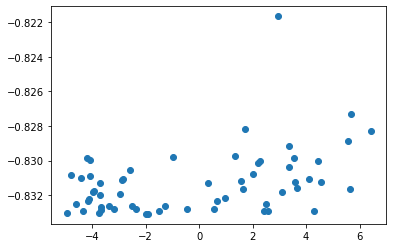

In [116]:
#Distance Function
plt.scatter(Stats["OFR FSI"], Stats["Stat_Values"])

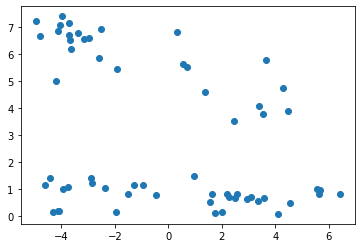

In [120]:
#Clustering Function
plt.scatter(Stats["OFR FSI"], Stats["Stat_Values"])